# Constructing Alzheimer's Detector 

[A. Data Set Information](#A.-Data-Set-Information)

[1. Imported Packages and Data](#1.-Imported-Packages-and-Data)

[2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)

[3. Data Cleaning](#3.-Data-Cleaning)

[4. Model Construction](#4.-Model-Construction)

[5. Hyperparameter Tuning](#5.-Hyperparameter-Tuning)

[6. Discussion](#6.-Discussion)

# A. Data Set Information

#### A.1 Summary

<b>Summary:</b>
This set consists of a longitudinal collection of 150 subjects aged 60 to 96. Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 72 of the subjects were characterized as nondemented throughout the study. 64 of the included subjects were characterized as demented at the time of their initial visits and remained so for subsequent scans, including 51 individuals with mild to moderate Alzheimer’s disease. Another 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit.

#### A.2 Column Descriptions

<pre>
- <b>Subject ID:</b> unique code assigned to each subject in the study
- <b>MRI ID:</b> unique code assigned to each MRI scan
- <b>Group:</b> subject classified under one of the three of the following
    - Nondemented
    - Demented 
    - Converted: intially grouped "Nondemented" and later "Demented"
- <b>Visit:</b> Visit number for patient

Demographics 
- <b>M/F:</b> patient gender
- <b>Hand:</b> handedness (all patients were right-handed)
- <b>Age:</b> age of patient in years
- <b>EDUC:</b> years of education
- <b>SES:</b> Socioeconomic status measured 1 (highest) to 5 (lowest)

Clinical Data
- <b>MMSE:</b> Mini Mental State Examination score
    - Scores range from 0 (worst) to 30 (best)
    - Scoring 30 doesn't completely rule out dementia
    - 24-30 = normal
    - 19-23 = mild
    - 10-18 = moderate
    - 0-9 = severe
- <b>CDR:</b> Clinical Dementia Rating
    - 0 = no dementia
    - 0.5 = very mild dementia
    - 1 = mild dementia
    - 2 = moderate dementia
    - 3 = severe dementia
- <b>eTIV:</b> estimated total intercranial volume
    - measured in mm^3
- <b>nWBV:</b> normalized whole-brain volume
- <b>ASF:</b> atlas scaling factor
    - Volume-scaling factor to match subject to atlas target
    - Used to correct for head size variation
    
</pre>

## 1. Imported Packages and Data

#### 1.1 Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("colorblind")

from sklearn.impute import SimpleImputer,KNNImputer

import warnings
warnings.filterwarnings('ignore')

#### 1.2 Parkinson's data set

## DEVELOP HYPOTHESIS FOR WHICH CLASSIFIER

In [3]:
### MERGE CONVERTED GROUP TO DEMENTED GROUP (result in binary class)

dem_df = pd.read_csv("oasis_longitudinal.csv")
dem_df.head()

print(dem_df["Group"].value_counts())

Nondemented    190
Demented       146
Converted       37
Name: Group, dtype: int64


## 2. Exploratory Data Analysis

## DESCRIPTIVE STATS FOR EACH GROUP (NONDEMENTED,DEMENTED)

In [3]:
dem_df.shape

(373, 15)

In [4]:
dem_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


In [5]:
dem_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Visit,373.0,1.882038,0.922843,1.000,1.000,2.000,2.000,5.000
MR Delay,373.0,595.104558,635.485118,0.000,0.000,552.000,873.000,2639.000
Age,373.0,77.013405,7.640957,60.000,71.000,77.000,82.000,98.000
EDUC,373.0,14.597855,2.876339,6.000,12.000,15.000,16.000,23.000
SES,354.0,2.460452,1.134005,1.000,2.000,2.000,3.000,5.000
MMSE,371.0,27.342318,3.683244,4.000,27.000,29.000,30.000,30.000
CDR,373.0,0.290885,0.374557,0.000,0.000,0.000,0.500,2.000
eTIV,373.0,1488.128686,176.139286,1106.000,1357.000,1470.000,1597.000,2004.000
nWBV,373.0,0.729568,0.037135,0.644,0.700,0.729,0.756,0.837
ASF,373.0,1.195461,0.138092,0.876,1.099,1.194,1.293,1.587


<AxesSubplot:>

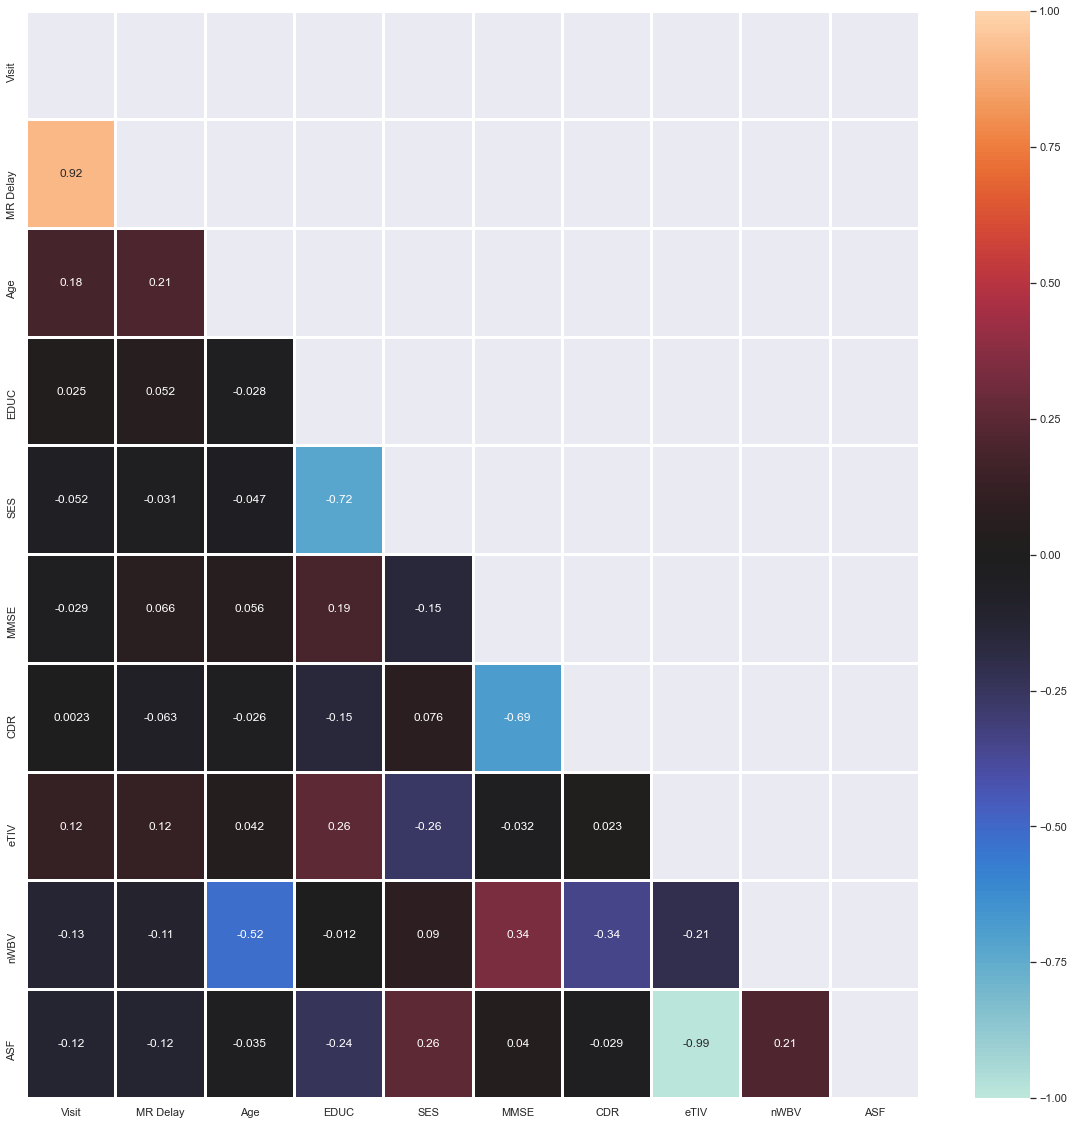

In [6]:
matrix = np.triu(dem_df.corr())
sns.set(rc = {'figure.figsize':(20,20)})
sns.heatmap(dem_df.corr(),annot=True,vmin=-1,vmax=1,center=0,linewidths=2,mask=matrix)

array([[<AxesSubplot:title={'center':'Visit'}>,
        <AxesSubplot:title={'center':'MR Delay'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'EDUC'}>,
        <AxesSubplot:title={'center':'SES'}>,
        <AxesSubplot:title={'center':'MMSE'}>],
       [<AxesSubplot:title={'center':'CDR'}>,
        <AxesSubplot:title={'center':'eTIV'}>,
        <AxesSubplot:title={'center':'nWBV'}>],
       [<AxesSubplot:title={'center':'ASF'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

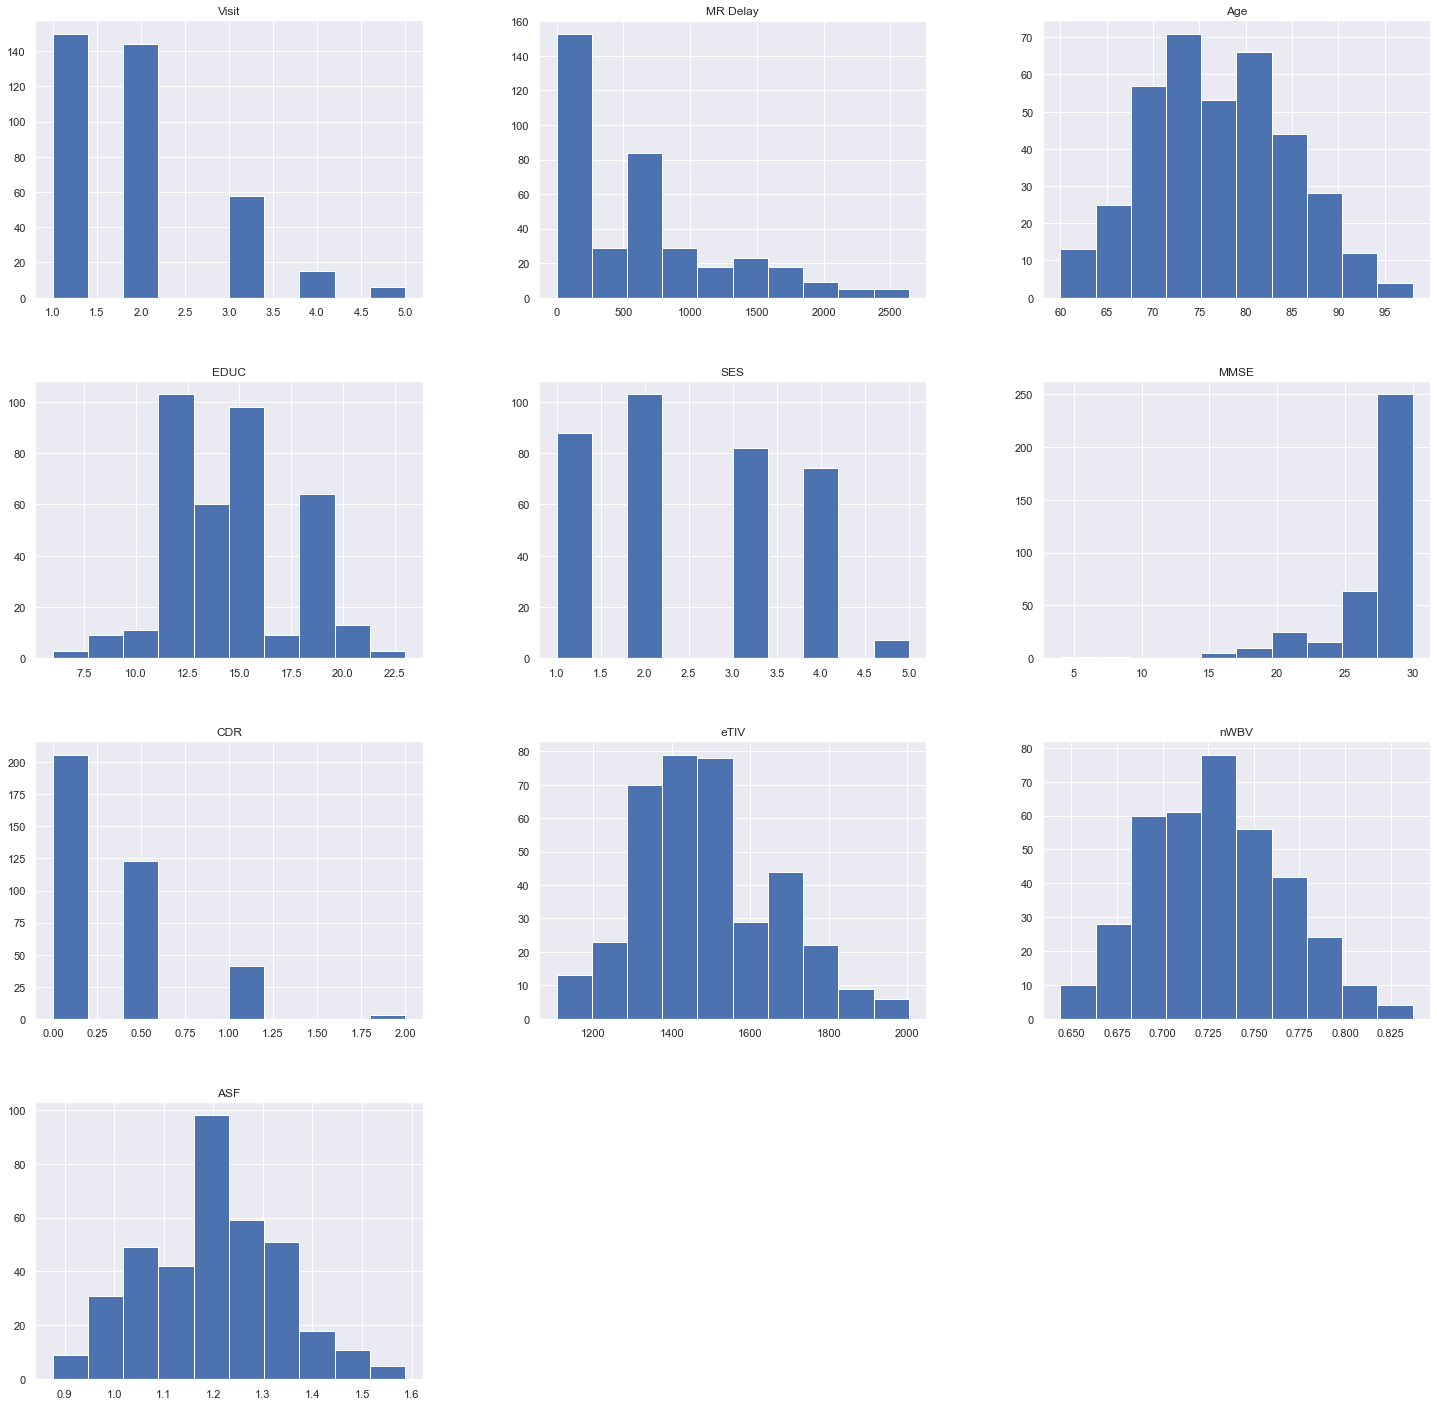

In [7]:
dem_df.hist(figsize=(25,25))

## 3. Data Cleaning

In [8]:
#Entire dataset is right-handed so I will drop this row
print(dem_df[["Hand"]].value_counts())
dem_df = dem_df.drop("Hand",axis=1)
dem_df.columns

Hand
R       373
dtype: int64


Index(['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Age',
       'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')

In [9]:
dem_df.duplicated().any()

False

In [10]:
dem_df.isna().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [11]:
dem_df[dem_df.isnull().any(axis=1)]

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,80,12,NaN,22.0,0.5,1698,0.701,1.034
10,OAS2_0007,OAS2_0007_MR1,Demented,1,0,M,71,16,NaN,28.0,0.5,1357,0.748,1.293
11,OAS2_0007,OAS2_0007_MR3,Demented,3,518,M,73,16,NaN,27.0,1.0,1365,0.727,1.286
12,OAS2_0007,OAS2_0007_MR4,Demented,4,1281,M,75,16,NaN,27.0,1.0,1372,0.710,1.279
134,OAS2_0063,OAS2_0063_MR1,Demented,1,0,F,80,12,NaN,30.0,0.5,1430,0.737,1.228
135,OAS2_0063,OAS2_0063_MR2,Demented,2,490,F,81,12,NaN,27.0,0.5,1453,0.721,1.208
207,OAS2_0099,OAS2_0099_MR1,Demented,1,0,F,80,12,NaN,27.0,0.5,1475,0.762,1.190
208,OAS2_0099,OAS2_0099_MR2,Demented,2,807,F,83,12,NaN,23.0,0.5,1484,0.750,1.183


In [12]:
median_imputer = SimpleImputer(missing_values=np.nan,strategy="median")

median_imputer.fit(dem_df[["MMSE"]])

dem_df[["MMSE"]] = median_imputer.fit_transform(dem_df[["MMSE"]])

dem_df[["MMSE"]].isna().sum()

MMSE    0
dtype: int64

In [16]:
dem_df["SES"].fillna(dem_df.groupby("EDUC")["SES"].transform("median"), inplace=True)

dem_df[["SES"]].isna().sum()

SES    0
dtype: int64

## 4. Model Construction

split train test, bootstrap
xgboost vs two classifiers*
90-10


## 5. Hyperparameter Tuning

## 6. Discussion

## SHAP ANALYSIS ON THE BEST CLASSIFIER